In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [46]:
import time
import gc
import matplotlib.pyplot as plt
import cupy as np
import numpy
import pandas as pd
from itertools import product
from pathlib import Path
from tqdm import tqdm
from abc import ABC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from src.NeuralNetwork import CudaNetwork, CudaLayer
from src.loss_functions import LossFunctions
from src.loss_functions import __LossFunctionBase__
from src.logging_tools import layer_agl_plot
from src.datasets import AirBnb, HeartDisease

In [39]:
def memory_state():
    mempool = np.get_default_memory_pool()
    gc.collect()
    pinned_mempool = np.get_default_pinned_memory_pool()
    mempool.free_all_blocks()              
    print("total (bytes):", mempool.total_bytes())
    print("used:", mempool.used_bytes())
    print("remainder:", (mempool.total_bytes() - mempool.used_bytes()))
    print("limit:", mempool.get_limit())           
    print("free blocks:", pinned_mempool.n_free_blocks())

In [40]:
memory_state()

total (bytes): 11677184
used: 349696
remainder: 11327488
limit: 0
free blocks: 3


### AirBNB Data Training Set

In [4]:
cap = 1500
airbnb = AirBnb()
X, y = airbnb.load_train_data()
X = X.drop('id', axis=1).values[:cap].astype(np.float16)
y = y.drop('id', axis=1).values.reshape(-1, 1)[:cap].astype(np.float16)
X = StandardScaler().fit_transform(X)
y = MinMaxScaler().fit_transform(y)

0.0 0.0


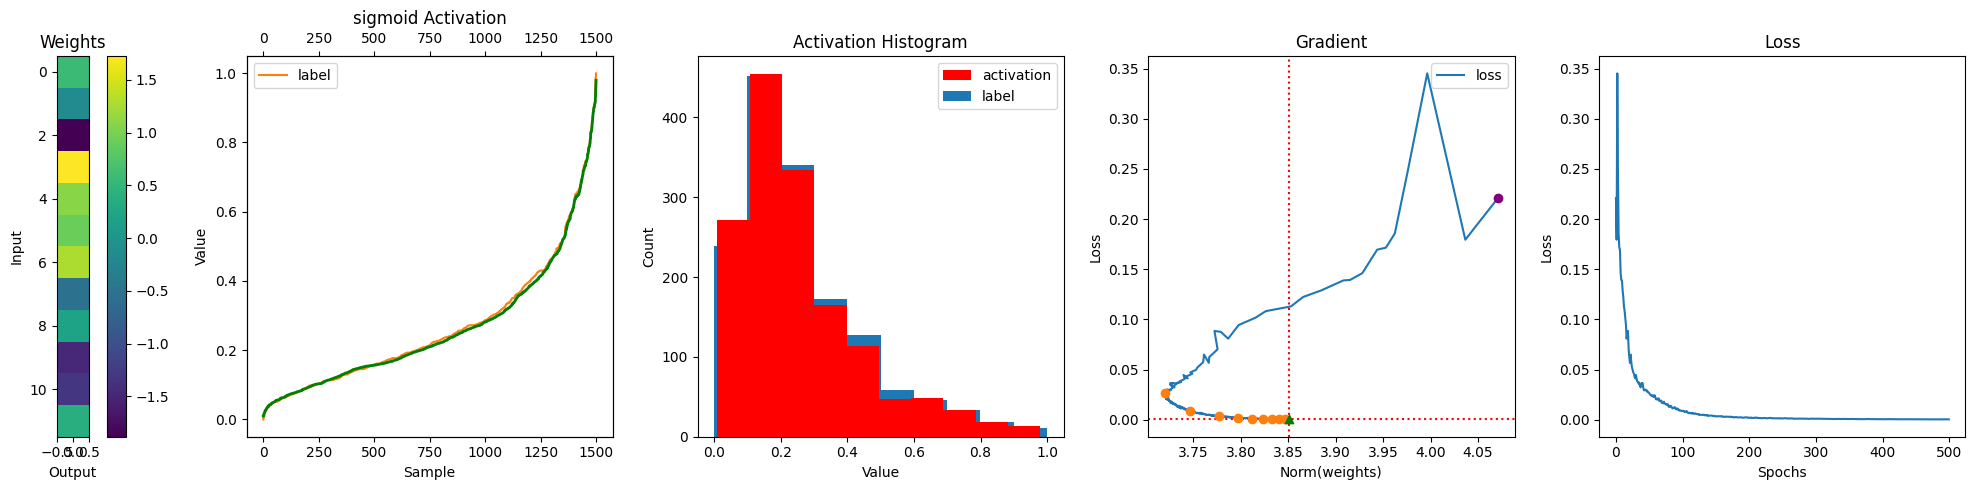

CPU times: user 5.98 s, sys: 1.17 s, total: 7.15 s
Wall time: 5.32 s


In [5]:
%%time
np.random.seed(0)
n = CudaNetwork()
n.set_loss_function(loss_function=LossFunctions.mse)
n.add(CudaLayer(output_size=120, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='rmsProp'))
n.add(CudaLayer(output_size=12, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='adaGrad'))
n.add(CudaLayer(output_size=1, act_f='sigmoid', w_init={'low': -2, 'high': 2, 'mode': 'uniform'}, optimizer='adaGrad'))
#n.describe()

loss = n.fit(X=X, y=y, lr=1.1e-10, epochs=500)
loss = [_.get() for _ in loss]
print(numpy.round(loss[-1], 2), round(numpy.min(numpy.abs(loss)), 2))
layer_agl_plot(layer=n.layers[-1], y=y, loss=loss)

### AirBNB Data Testing Set

In [6]:
X, y = airbnb.load_test_data()
X = X.drop('id', axis=1).values[:cap].astype(np.float16)
y = y.drop('id', axis=1).values.reshape(-1, 1)[:cap].astype(np.float16)
X = StandardScaler().fit_transform(X)
y = MinMaxScaler().fit_transform(y)
X.shape

(1500, 153)

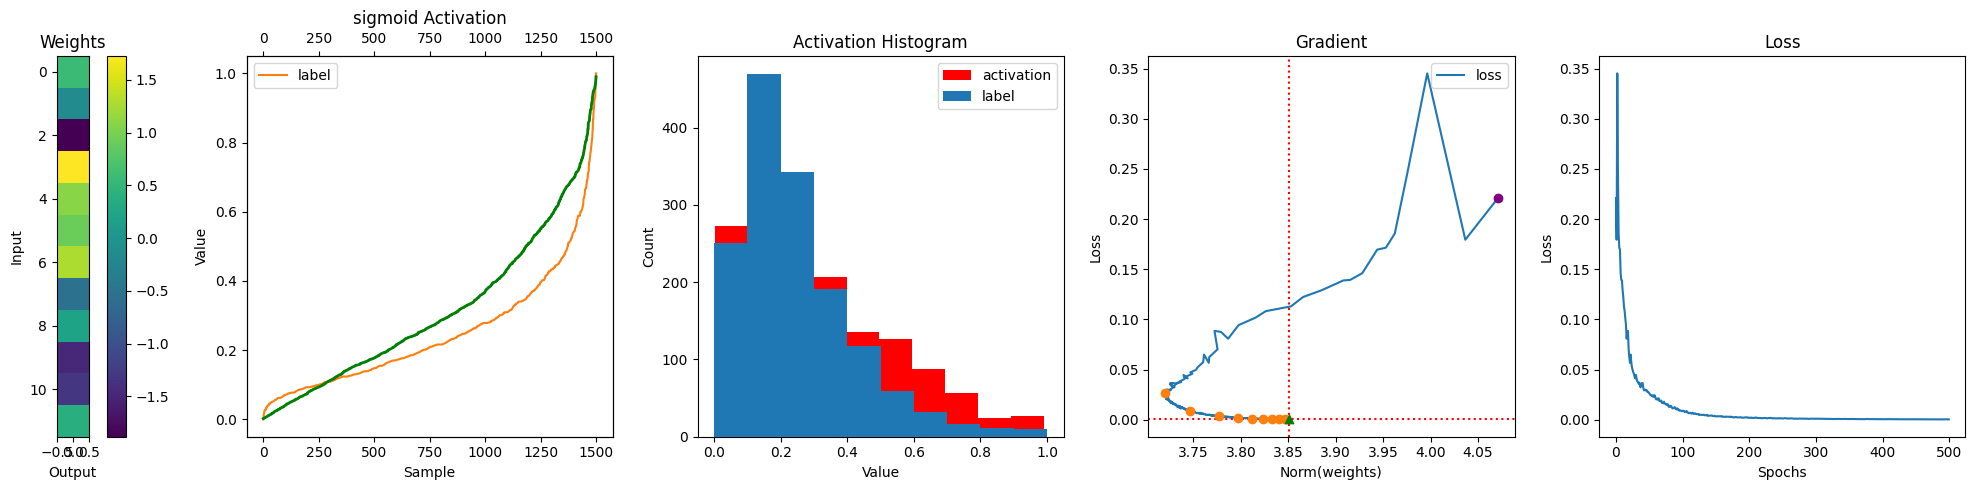

In [7]:
pred = n.predict(X=X)
layer_agl_plot(layer=n.layers[-1], y=y, loss=loss)

### HeartDisease Data Training Set

In [8]:
heartDisease = HeartDisease()
data = heartDisease.load_data()

In [9]:
from sklearn.preprocessing import OrdinalEncoder

In [10]:
for col in data.columns:
    if data.dtypes[col] != np.float64:
        vc = data[col].value_counts()
        for idx, value in enumerate(vc.index):
            data.loc[data[col]==value, col] = idx

In [26]:
cap = 2500
data = data.astype(np.float16)
X_hd = data.drop('HeartDisease', axis=1).values
y_hd = data.HeartDisease.values
X_kd = data.drop('KidneyDisease', axis=1).values
y_kd = data.KidneyDisease.values

X_hd = StandardScaler().fit_transform(X_hd)[:cap]
y_hd = MinMaxScaler().fit_transform(y_hd.reshape(-1, 1))[:cap]
X_kd = StandardScaler().fit_transform(X_kd)[:cap]
y_kd = MinMaxScaler().fit_transform(y_kd.reshape(-1, 1))[:cap]

### HeartDisease

0.05 0.04
acc: 0.95
[[2173   92]
 [  30  205]]


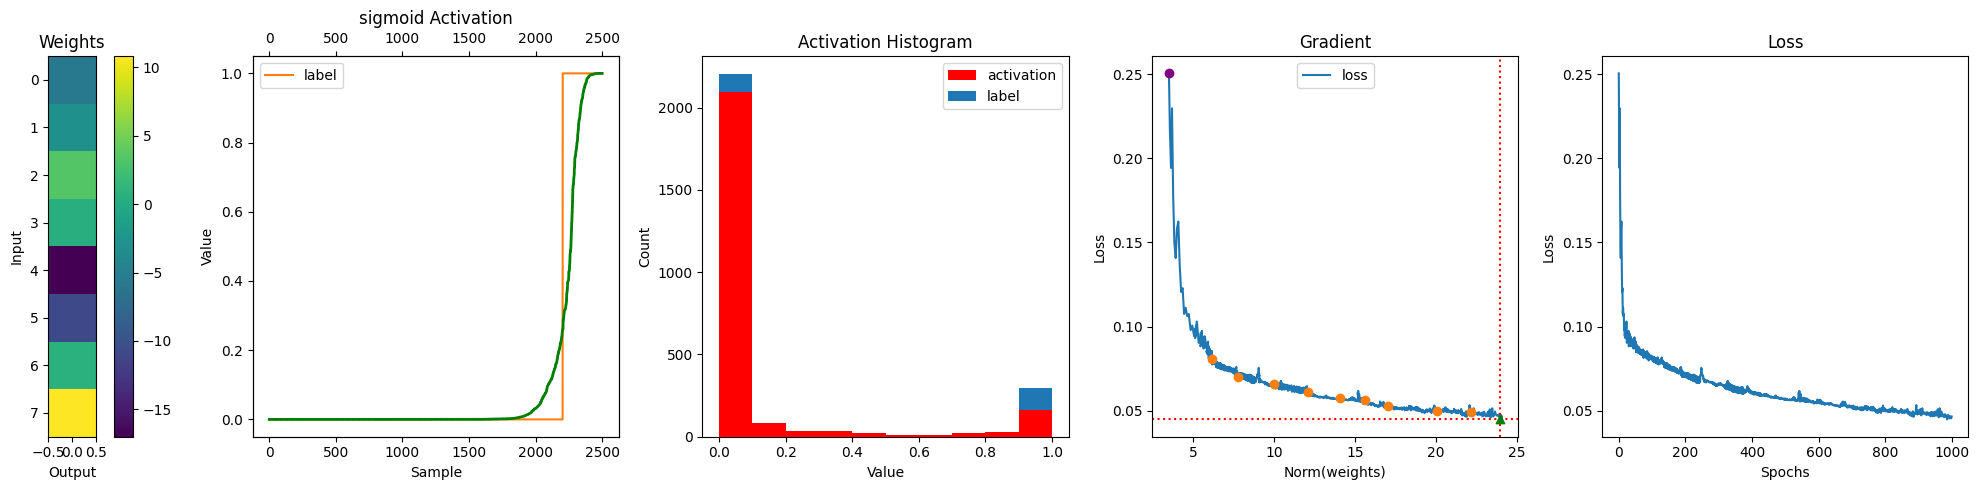

CPU times: user 9.76 s, sys: 934 ms, total: 10.7 s
Wall time: 8.96 s


In [53]:
%%time
np.random.seed(0)
n = CudaNetwork(round_off=1)
n.set_loss_function(loss_function=LossFunctions.mse)
n.add(CudaLayer(output_size=12, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='rmsProp'))
n.add(CudaLayer(output_size=12, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='adaGrad'))
n.add(CudaLayer(output_size=8, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='adaGrad'))
n.add(CudaLayer(output_size=1, act_f='sigmoid', w_init={'low': -2, 'high': 2, 'mode': 'uniform'}, optimizer='adam'))
#n.describe()

loss = n.fit(X=X_hd, y=y_hd, lr=1.1e-8, epochs=1000)
loss = [_.get() for _ in loss]
conf = confusion_matrix(np.round(n.layers[-1].state()[0]).get(), y_hd)
diag = np.diag(conf[:, ::-1])
print(numpy.round(loss[-1], 2), round(numpy.min(numpy.abs(loss)), 2))
print("acc:", np.round(1 - np.sum(diag)/np.sum(conf), 2))
print(conf)
layer_agl_plot(layer=n.layers[-1], y=y_hd, loss=loss)

In [54]:
memory_state()

total (bytes): 756285440
used: 663091200
remainder: 93194240
limit: 0
free blocks: 5


### Kidney Disease

0.01 0.01
acc: 0.99
[[2367   31]
 [   2  100]]


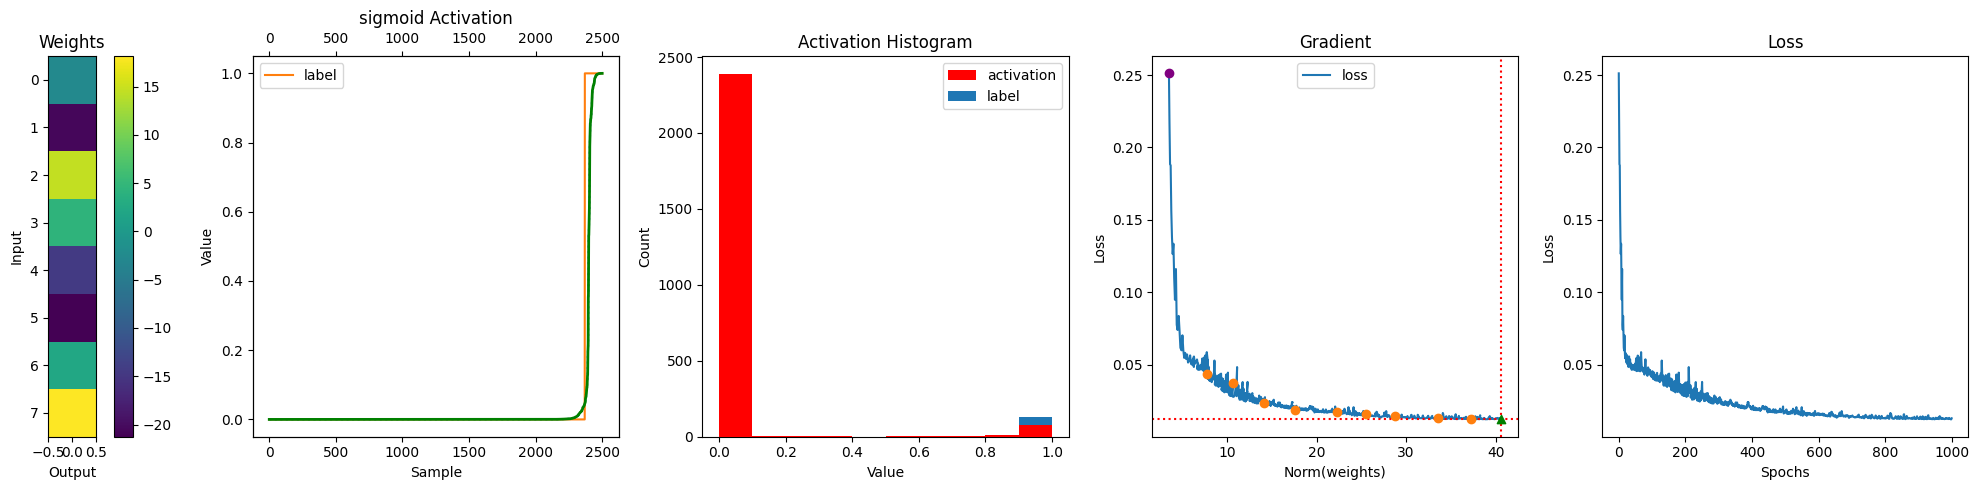

CPU times: user 9.45 s, sys: 865 ms, total: 10.3 s
Wall time: 8.58 s


In [55]:
%%time
np.random.seed(0)
n = CudaNetwork(round_off=1)
n.set_loss_function(loss_function=LossFunctions.mse)
n.add(CudaLayer(output_size=12, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='rmsProp'))
n.add(CudaLayer(output_size=12, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='adaGrad'))
n.add(CudaLayer(output_size=8, act_f='tanh', w_init={'low': -.1, 'high': .1, 'mode': 'uniform'}, optimizer='adaGrad'))
n.add(CudaLayer(output_size=1, act_f='sigmoid', w_init={'low': -2, 'high': 2, 'mode': 'uniform'}, optimizer='adam'))
#n.describe()

loss = n.fit(X=X_kd, y=y_kd, lr=1.1e-8, epochs=1000)
loss = [_.get() for _ in loss]
conf = confusion_matrix(np.round(n.layers[-1].state()[0]).get(), y_kd)
diag = np.diag(conf[:, ::-1])
print(numpy.round(loss[-1], 2), round(numpy.min(numpy.abs(loss)), 2))
print("acc:", np.round(1 - np.sum(diag)/np.sum(conf), 2))
print(conf)
layer_agl_plot(layer=n.layers[-1], y=y_kd, loss=loss)